In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN
import seaborn as sns
from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas_ta as ta
import IPython
import IPython.display
plt.style.use('seaborn-darkgrid')

In [2]:
path_to_file = "btc.csv"

In [3]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'})
times = btc['date']
btc.drop('date', axis=1, inplace=True)
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)
df = btc
df.head()

,open,high,low,close,Volume BTC
624,11332.26,11555.61,11277.95,11536.58,6046.497464
623,11538.74,11592.00,11423.64,11471.71,2095.936003
622,11471.71,11715.69,11458.62,11708.97,2328.657019
621,11713.11,11780.00,11573.39,11655.00,4534.218102
620,11658.48,12065.82,11515.00,11923.96,7960.822380


In [4]:
timestamp_s = times.map(pd.Timestamp.timestamp)
timestamp_s

624    1.598573e+09
623    1.598659e+09
622    1.598746e+09
621    1.598832e+09
620    1.598918e+09
           ...     
4      1.652141e+09
3      1.652227e+09
2      1.652314e+09
1      1.652400e+09
0      1.652486e+09
Name: date, Length: 625, dtype: float64

Text(0.5, 1.0, 'Time of day signal')

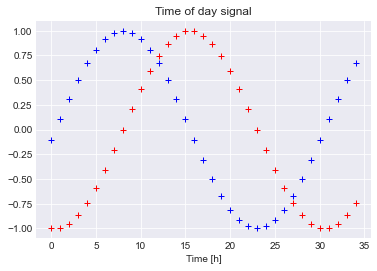

In [5]:
day = 24*60*60
mounth = day * 30
year = (365.2425)*day

btc['mounth sin'] = np.sin(timestamp_s * (2 * np.pi / mounth))
btc['mounth cos'] = np.cos(timestamp_s * (2 * np.pi / mounth))
btc['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
btc['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(btc['mounth sin'])[:35], 'r+')
plt.plot(np.array(btc['mounth cos'])[:35], 'b+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [6]:
# analaiz and split data
column_indices = {name: i for i, name in enumerate(btc.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# n, num_features, column_indices

In [7]:
# standard
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

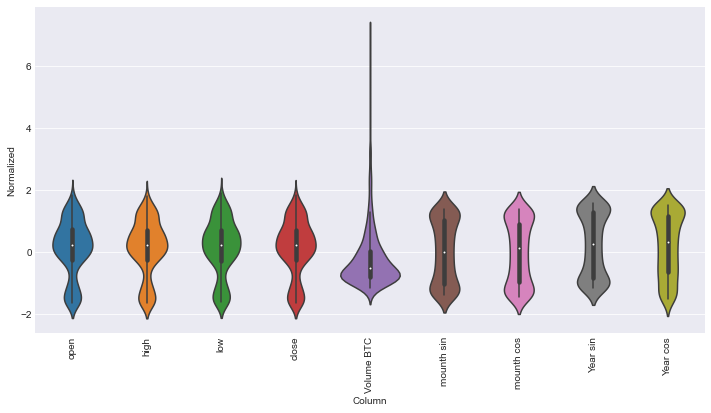

In [8]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None, example = None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.train_df_ = train_df.copy()
        self.val_df_ = val_df.copy()
        self.test_df_ = test_df.copy()
        
        try:
            self.example = example
        except:
            pass

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        self.inputs = inputs
        self.labels = labels
        return inputs, labels
    
    def split_window_inputs_labels(self,features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        inputs__ = features[:, self.input_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            inputs_labels_ = tf.stack([inputs__[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        
        inputs_labels_.set_shape([None, self.label_width, None])
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return ((inputs, inputs_labels_), labels)
    
    def split_window_Ir(self,features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        inputs__ = features[:, self.input_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            inputs_labels_ = tf.stack([inputs__[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            inputs_labels_ = inputs_labels_[:, -3:, :]
            
        inputs_labels_.set_shape([None, 3, None])
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return ((inputs, inputs_labels_), labels)
    
    def plot(self, model=None, train___=True, nIr=True, plot_col='close', max_subplots=3):
        if self.example:
            if train___:
                self.inputs1, self.labels = self.example
            else:
                if nIr:
                    (self.inputs1, self.inputs2), self.labels = self.example_
                else:
                    (self.inputs1, self.inputs2), self.labels = self.example_Ir
            
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(self.inputs1))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, self.inputs1[n, :, plot_col_index],
                  label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, self.labels[n, :, label_col_index],
                      edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                if train___:
                    predictions = model(self.inputs1)
                    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                marker='X', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)
                else:
                    if nIr:
                        predictions = model([self.inputs1, self.inputs2])
                        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                    marker='X', edgecolors='k', label='Predictions',
                                    c='#ff7f0e', s=64)
                    else:
                        predictions = model([self.inputs1, self.inputs2])
                        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                    marker='X', edgecolors='k', label='Predictions',
                                    c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
        
    def make_dataset(self, data, split_window):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=64,)

        ds = ds.map(split_window)
        return ds
    
@property
def train(self):
    return self.make_dataset(self.train_df, self.split_window)

@property
def val(self):
    return self.make_dataset(self.val_df, self.split_window)

@property
def test(self):
    return self.make_dataset(self.test_df, self.split_window)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result




@property
def train_(self):
    return self.make_dataset(self.train_df_, self.split_window_inputs_labels)

@property
def val_(self):
    return self.make_dataset(self.val_df_, self.split_window_inputs_labels)

@property
def test_(self):
    return self.make_dataset(self.test_df_, self.split_window_inputs_labels)

@property
def example_(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example_', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train_))
        # And cache it for next time
        self._example_ = result
    return result


@property
def train_Ir(self):
    return self.make_dataset(self.train_df_, self.split_window_Ir)

@property
def val_Ir(self):
    return self.make_dataset(self.val_df_, self.split_window_Ir)

@property
def test_Ir(self):
    return self.make_dataset(self.test_df_, self.split_window_Ir)

@property
def example_Ir(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example_Ir', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train_Ir))
        # And cache it for next time
        self._example_Ir = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

WindowGenerator.train_ = train_
WindowGenerator.val_ = val_
WindowGenerator.test_ = test_
WindowGenerator.example_ = example_

WindowGenerator.train_Ir = train_Ir
WindowGenerator.val_Ir = val_Ir
WindowGenerator.test_Ir = test_Ir
WindowGenerator.example_Ir = example_Ir

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [18 19 20 21 22 23 24]
Label column name(s): ['close']



((TensorSpec(shape=(None, 24, 9), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None)),
 TensorShape([64, 24, 9]),
 TensorShape([64, 7, 1]))

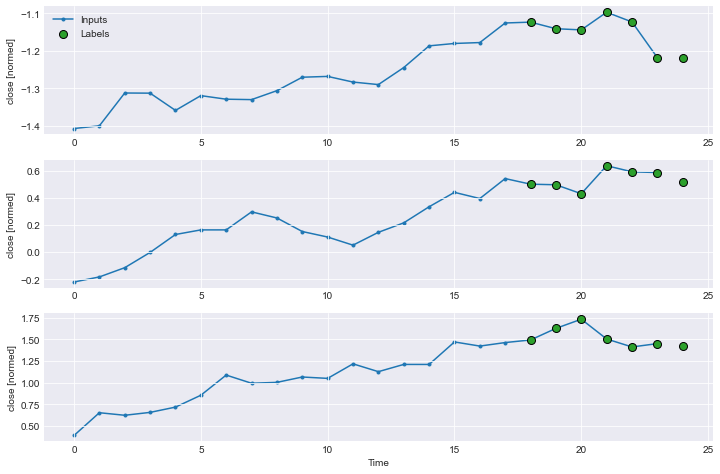

In [10]:
#ex : 

w = WindowGenerator(input_width=24, label_width=7, shift=1, label_columns=['close'])

print(w, end='\n\n')

# # Stack three slices, the length of the total window.
# example_window = tf.stack([np.array(train_df[:w.total_window_size]),
#                            np.array(train_df[100:100+w.total_window_size]),
#                            np.array(train_df[200:200+w.total_window_size])])

# example_inputs, example_labels = w.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'Labels shape: {example_labels.shape}')

w.plot()
# w.plot(plot_col='open')


# Each element is an (inputs, label) pair.
w.train.element_spec, w.example[0].shape, w.example[1].shape
# a = w.inputs_label

### Model

In [11]:
def compile_and_fit(model, window, patience=100, train__=True, nIr=True, MAX_EPOCHS=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    if train__ :
        history = model.fit(window.train, epochs=MAX_EPOCHS,
                              validation_data=window.val,
                              callbacks=[early_stopping])
    else:
        if nIr:
            history = model.fit(window.train_, epochs=MAX_EPOCHS,
                                  validation_data=window.val_,
                                  callbacks=[early_stopping])
        else:
            history = model.fit(window.train_Ir, epochs=MAX_EPOCHS,
                                  validation_data=window.val_Ir,
                                  callbacks=[early_stopping])

    return history

# Many to Many OutPut One

Inputs shape (batch, time, features): (64, 30, 9)
Labels shape (batch, time, features): (64, 30, 1)
30 9 1


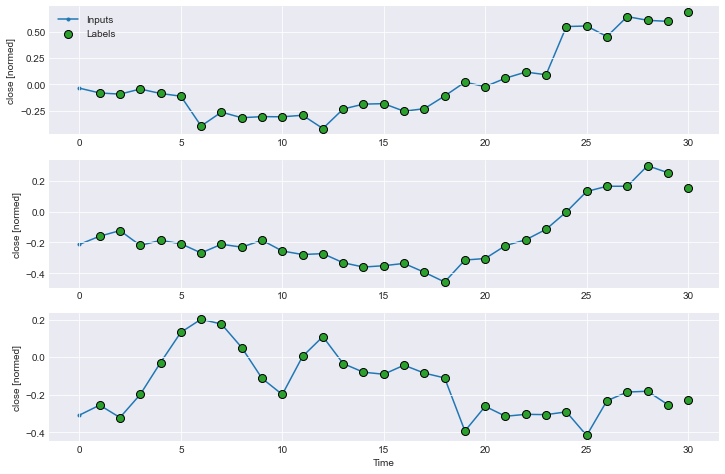

In [12]:
Many2ManyO1 = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['close'])

for example_inputs, example_labels in Many2ManyO1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

num_time = example_labels.shape[1]
num_features = example_labels.shape[2]
num_features_i = example_inputs.shape[2]
print(num_time, num_features_i, num_features)

val_performance_Many2ManyO1 = {}
performance_Many2ManyO1 = {}

Many2ManyO1
Many2ManyO1.plot()

##### linear

2/2 [==============================] - 0s 2ms/step - loss: 0.1178 - mean_absolute_error: 0.2757
Input shape: (64, 30, 9)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30, 1)             10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
None


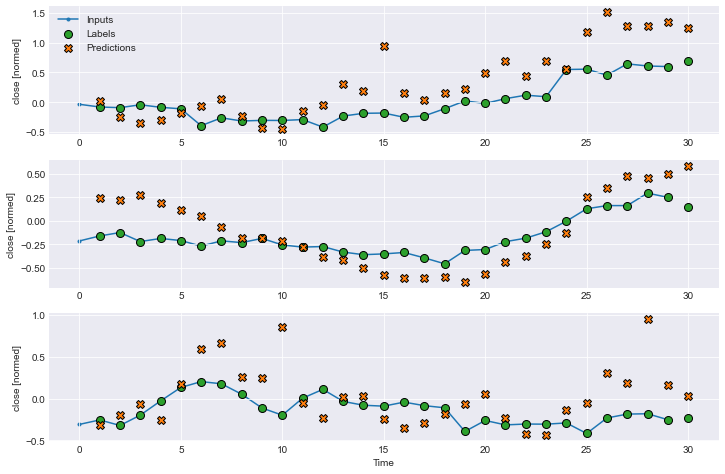

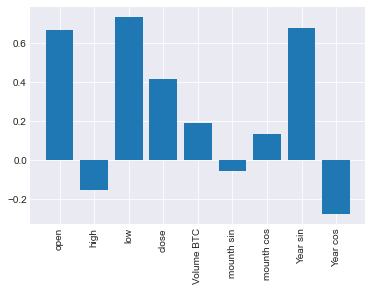

In [13]:
linear_Many2ManyO1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


history = compile_and_fit(linear_Many2ManyO1, Many2ManyO1)
IPython.display.clear_output()

val_performance_Many2ManyO1['Linear'] = linear_Many2ManyO1.evaluate(Many2ManyO1.val)
performance_Many2ManyO1['Linear'] = linear_Many2ManyO1.evaluate(Many2ManyO1.test, verbose=0)

print('Input shape:', Many2ManyO1.example[0].shape)

print(linear_Many2ManyO1.summary())

Many2ManyO1.plot(linear_Many2ManyO1)

# One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights and visualize the weight assigned to each input:
plt.figure()
plt.bar(x = range(len(train_df.columns)),
        height=linear_Many2ManyO1.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

##### dense

2/2 [==============================] - 0s 998us/step - loss: 0.0262 - mean_absolute_error: 0.1283
Input shape: (64, 30, 9)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30, 64)            640       
                                                                 
 dense_2 (Dense)             (None, 30, 64)            4160      
                                                                 
 dense_3 (Dense)             (None, 30, 1)             65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


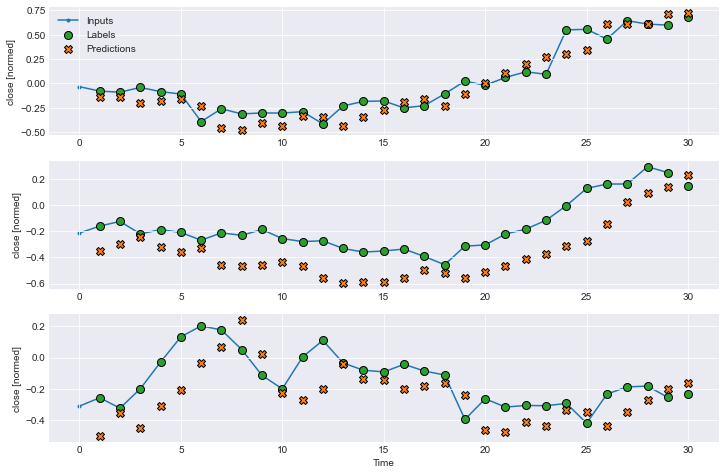

In [14]:
dense_Many2ManyO1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense_Many2ManyO1, Many2ManyO1)
IPython.display.clear_output()

val_performance_Many2ManyO1['Dense'] = dense_Many2ManyO1.evaluate(Many2ManyO1.val)
performance_Many2ManyO1['Dense'] = dense_Many2ManyO1.evaluate(Many2ManyO1.test, verbose=0)

print('Input shape:', Many2ManyO1.example[0].shape)

print(dense_Many2ManyO1.summary())

Many2ManyO1.plot(dense_Many2ManyO1)

##### conv 1D

2/2 [==============================] - 0s 1ms/step - loss: 0.2318 - mean_absolute_error: 0.3713
Conv model on `conv_window`
Input shape: (64, 30, 9)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 28, 64)            1792      
                                                                 
 dense_4 (Dense)             (None, 28, 30)            1950      
                                                                 
 reshape (Reshape)           (None, 30, 28)            0         
                                                                 
 dense_5 (Dense)             (None, 30, 1)             29        
                                                                 
Total params: 3,771
Trainable params: 3,771


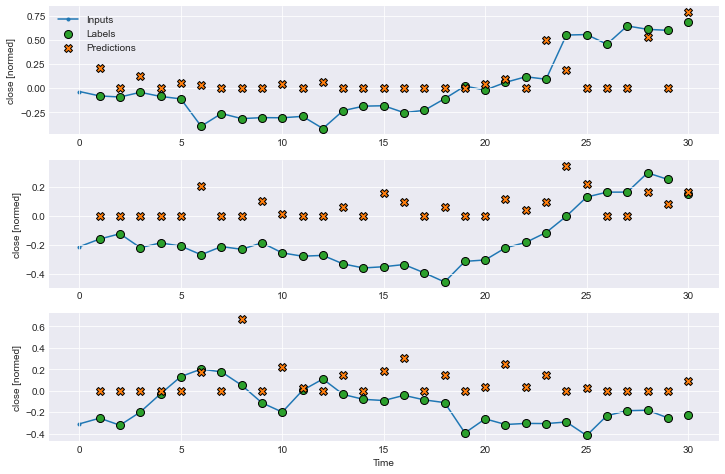

In [15]:
i = tf.keras.layers.Input(shape=(num_time, num_features_i))
x = tf.keras.layers.Conv1D(filters=64, kernel_size=(3,), activation='relu')(i)
x = tf.keras.layers.Dense(units=num_time, activation='relu')(x)
x = tf.keras.layers.Reshape((num_time, -1))(x)
o = tf.keras.layers.Dense(units=1, activation='relu')(x)

conv_model_Many2ManyO1 = tf.keras.Model(i, o)
print(conv_model_Many2ManyO1.summary())
print('Input shape:', Many2ManyO1.example[0].shape)                     
history = compile_and_fit(conv_model_Many2ManyO1, Many2ManyO1)
IPython.display.clear_output()

val_performance_Many2ManyO1['Conv'] = conv_model_Many2ManyO1.evaluate(Many2ManyO1.val)
performance_Many2ManyO1['Conv'] = conv_model_Many2ManyO1.evaluate(Many2ManyO1.test, verbose=0)

print("Conv model on `conv_window`")
print('Input shape:', Many2ManyO1.example[0].shape)

print(conv_model_Many2ManyO1.summary())

Many2ManyO1.plot(conv_model_Many2ManyO1)

#### Lstm

2/2 [==============================] - 0s 9ms/step - loss: 0.2003 - mean_absolute_error: 0.3809
Input shape: (64, 30, 9)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            5376      
                                                                 
 dense_6 (Dense)             (None, 30, 1)             33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
None


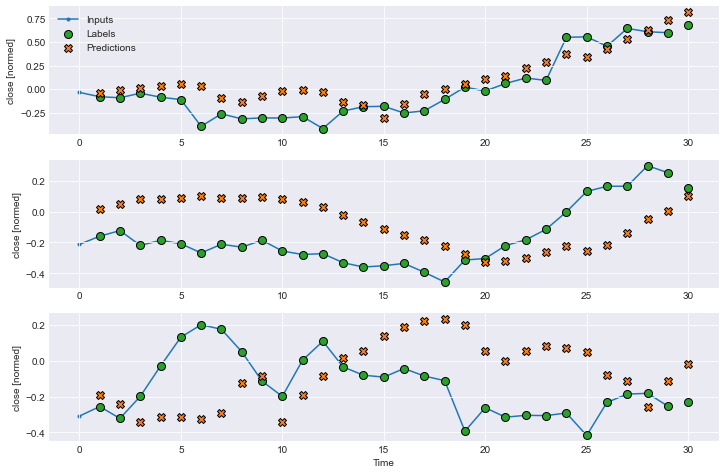

In [16]:
lstm_model_Many2ManyO1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_Many2ManyO1, Many2ManyO1)
IPython.display.clear_output()

val_performance_Many2ManyO1['LSTM'] = lstm_model_Many2ManyO1.evaluate(Many2ManyO1.val)
performance_Many2ManyO1['LSTM'] = lstm_model_Many2ManyO1.evaluate(Many2ManyO1.test, verbose=0)

print('Input shape:', Many2ManyO1.example[0].shape)

print(lstm_model_Many2ManyO1.summary())

Many2ManyO1.plot(lstm_model_Many2ManyO1)

### OutPut

Linear      : 1.1506
Dense       : 0.3227
Conv        : 0.2966
LSTM        : 0.5033


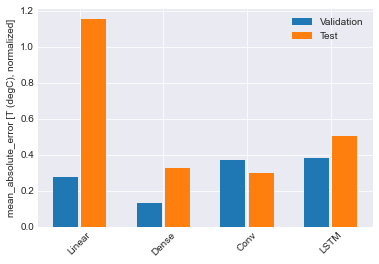

In [17]:
x = np.arange(len(performance_Many2ManyO1))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = linear_Many2ManyO1.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_Many2ManyO1.values()]
test_mae = [v[metric_index] for v in performance_Many2ManyO1.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_Many2ManyO1.keys(),
           rotation=45)
_ = plt.legend()


for name, value in performance_Many2ManyO1.items():
    print(f'{name:12s}: {value[1]:0.4f}')

#  Many to One

Inputs shape (batch, time, features): (64, 14, 9)
Labels shape (batch, time, features): (64, 1, 1)
1 1 9


Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['close']

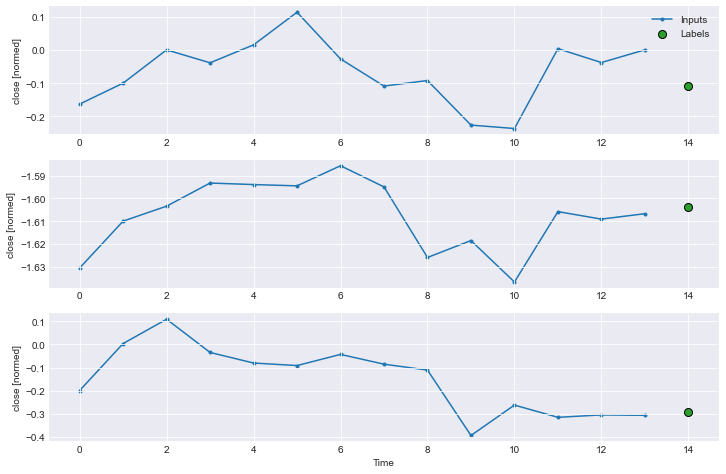

In [18]:
InputWidth = 14
Many2One = WindowGenerator(input_width=InputWidth, label_width=1, shift=1, label_columns=['close'])

for example_inputs, example_labels in Many2One.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

num_time = example_labels.shape[1]
num_features = example_labels.shape[2]
num_time_i = example_inputs.shape[1]
print(num_time,num_features,num_features_i)

val_performance_Many2One = {}
performance_Many2One = {}

Many2One.plot()
Many2One

##### multi_step_dense

2/2 [==============================] - 0s 0s/step - loss: 0.1516 - mean_absolute_error: 0.3168
Input shape: (64, 14, 9)


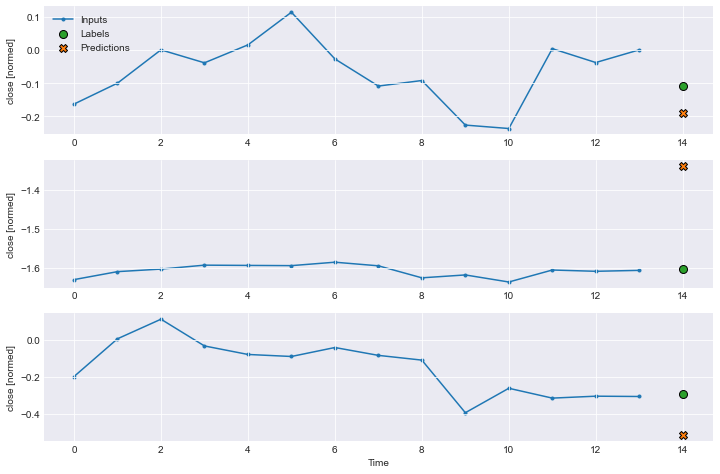

In [19]:
multi_step_dense_Many2One = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense_Many2One, Many2One)
IPython.display.clear_output()

val_performance_Many2One['Multi step dense'] = multi_step_dense_Many2One.evaluate(Many2One.val)
performance_Many2One['Multi step dense'] = multi_step_dense_Many2One.evaluate(Many2One.test, verbose=0)

print('Input shape:', Many2One.example[0].shape)

Many2One.plot(multi_step_dense_Many2One)

##### conv 1D

2/2 [==============================] - 0s 0s/step - loss: 0.1370 - mean_absolute_error: 0.3194
Conv model on `conv_window`
Input shape: (64, 14, 9)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 34)             4318      
                                                                 
 dense_10 (Dense)            (None, 1, 32)             1120      
                                                                 
 dense_11 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 5,471
Trainable params: 5,471
Non-trainable params: 0
_________________________________________________________________
None


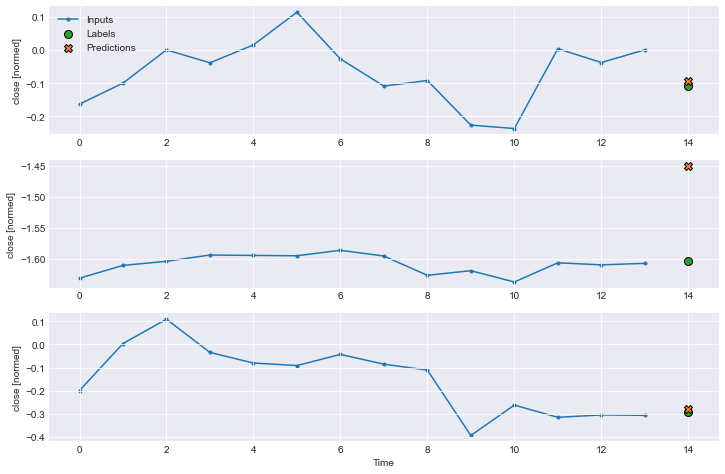

In [20]:
conv_model_Many2One = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=34,
                           kernel_size=(num_time_i),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model_Many2One, Many2One)
IPython.display.clear_output()

val_performance_Many2One['Conv'] = conv_model_Many2One.evaluate(Many2One.val)
performance_Many2One['Conv'] = conv_model_Many2One.evaluate(Many2One.test, verbose=0)

print("Conv model on `conv_window`")
print('Input shape:', Many2One.example[0].shape)

print(conv_model_Many2One.summary())

Many2One.plot(conv_model_Many2One)

Inputs shape (batch, time, features): (64, 33, 9)
Labels shape (batch, time, features): (64, 20, 1)
Total window size: 34
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Label column name(s): ['close']


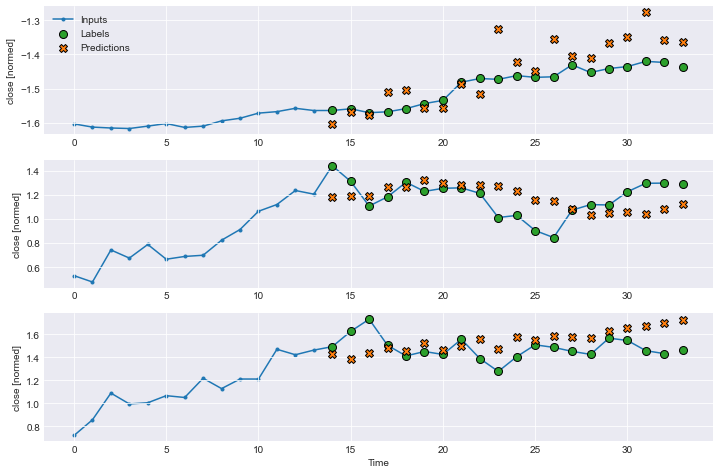

In [21]:
# Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.

LABEL_WIDTH = 20
INPUT_WIDTH = LABEL_WIDTH + (InputWidth - 1)
Many2OneSeries = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['close'])


val_performance_Many2OneSeries = {}
performance_Many2OneSeries = {}

for example_inputs, example_labels in Many2OneSeries.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
print(Many2OneSeries)


# test series 
Many2OneSeries.plot(conv_model_Many2One)

#### Lstm

2/2 [==============================] - 0s 16ms/step - loss: 0.1320 - mean_absolute_error: 0.3276
Input shape: (64, 14, 9)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5376      
                                                                 
 reshape_2 (Reshape)         (None, 1, 32)             0         
                                                                 
 dense_12 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
None


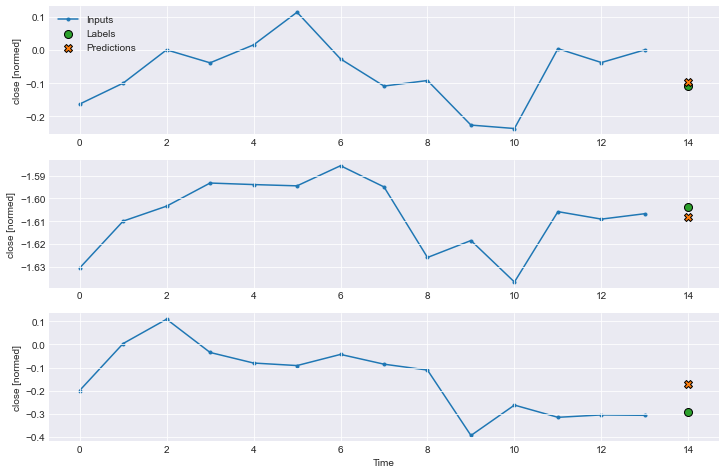

In [22]:
lstm_model_Many2One = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Reshape((1, 32)),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_Many2One, Many2One)
IPython.display.clear_output()

val_performance_Many2One['LSTM'] = lstm_model_Many2One.evaluate(Many2One.val)
performance_Many2One['LSTM'] = lstm_model_Many2One.evaluate(Many2One.test, verbose=0)

print('Input shape:', Many2One.example[0].shape)

print(lstm_model_Many2One.summary())

Many2One.plot(lstm_model_Many2One)

### OutPut

Multi step dense: 0.3342
Conv        : 0.2614
LSTM        : 0.2498


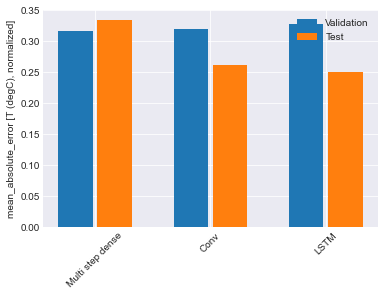

In [23]:
x = np.arange(len(performance_Many2One))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_step_dense_Many2One.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_Many2One.values()]
test_mae = [v[metric_index] for v in performance_Many2One.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_Many2One.keys(),
           rotation=45)
_ = plt.legend()


for name, value in performance_Many2One.items():
    print(f'{name:12s}: {value[1]:0.4f}')

# Many to Many

Inputs shape (batch, time, features): (64, 14, 9)
Labels shape (batch, time, features): (64, 14, 1)
14 9 1


Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['close']

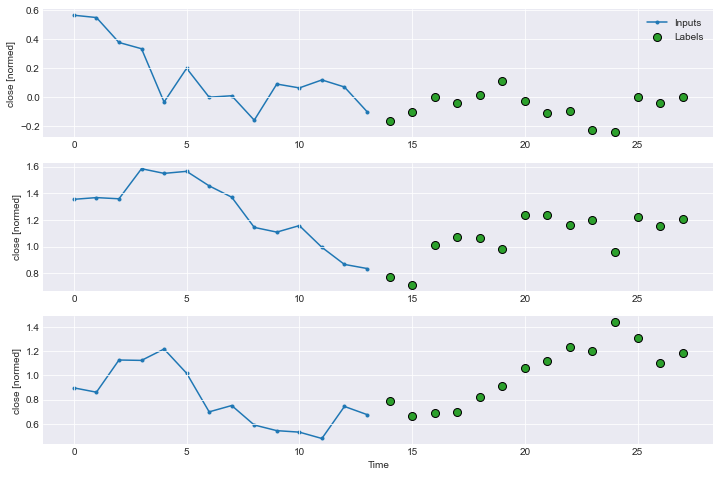

In [24]:
# in put != out put

InputWidth , OuputWidth, Shift = 14, 14, 14

M2M = WindowGenerator(
    input_width=InputWidth,
    label_width=OuputWidth,
    shift=Shift,
    label_columns=['close'])


val_performance_M2M = {}
performance_M2M = {}

for example_inputs, example_labels in M2M.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
num_time = example_labels.shape[1]
num_features_i = example_inputs.shape[2]
num_features = example_labels.shape[2]
print(num_time, num_features_i, num_features)

M2M.plot()
M2M

##### lstm

2/2 [==============================] - 0s 4ms/step - loss: 0.2322 - mean_absolute_error: 0.4160
Input shape: (64, 14, 9)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 32)            5376      
                                                                 
 dense_13 (Dense)            (None, 14, 1)             33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
None


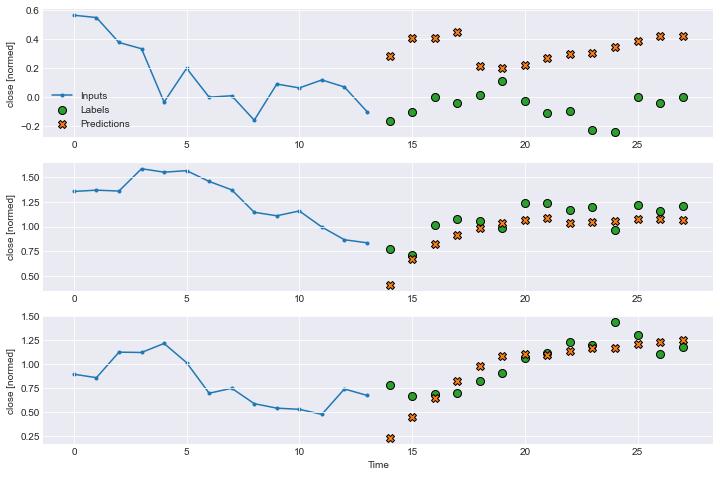

In [25]:
lstm_model_M2M = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model_M2M, M2M)
IPython.display.clear_output()

val_performance_M2M['LSTM'] = lstm_model_M2M.evaluate(M2M.val)
performance_M2M['LSTM'] = lstm_model_M2M.evaluate(M2M.test, verbose=0)

print('Input shape:', M2M.example[0].shape)

print(lstm_model_M2M.summary())

M2M.plot(lstm_model_M2M)

#### Residual LSTM

2/2 [==============================] - 0s 2ms/step - loss: 0.1192 - mean_absolute_error: 0.2888
Input shape: (64, 14, 9)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 14, 9)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 14, 32)       5376        ['input_2[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 14, 1)        33          ['lstm_3[0][0]']                 
                                                                                                  
 input_3 (InputLayer)           [(None, 14, 1)]      0           []   

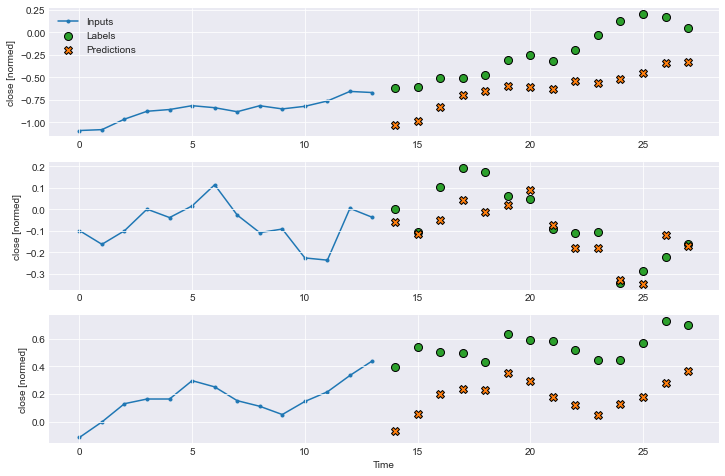

In [26]:
i = tf.keras.layers.Input(shape=(num_time, num_features_i))
ii = tf.keras.layers.Input(shape=(num_time, num_features))
x = tf.keras.layers.LSTM(32, return_sequences=True)(i)
x = tf.keras.layers.Dense(num_features, kernel_initializer=tf.initializers.zeros())(x)
# x = tf.keras.layers.Reshape([num_time, num_features])(x)
o = x + ii

residual_lstm_M2M = tf.keras.Model(inputs=[i,ii], outputs=o)


history = compile_and_fit(residual_lstm_M2M, window=M2M, train__=False)
IPython.display.clear_output()

val_performance_M2M['Residual LSTM'] = residual_lstm_M2M.evaluate(M2M.val_)
performance_M2M['Residual LSTM'] = residual_lstm_M2M.evaluate(M2M.test_, verbose=0)

print('Input shape:', M2M.example[0].shape)

print(residual_lstm_M2M.summary())

M2M.plot(residual_lstm_M2M, train___=False)

### OutPut

LSTM        : 0.3677
Residual LSTM: 0.2095


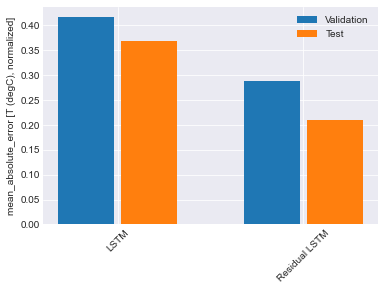

In [27]:
x = np.arange(len(performance_M2M))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model_M2M.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_M2M.values()]
test_mae = [v[metric_index] for v in performance_M2M.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_M2M.keys(),
           rotation=45)
_ = plt.legend()


for name, value in performance_M2M.items():
    print(f'{name:12s}: {value[1]:0.4f}')

# Many to Many Irregular

Inputs shape (batch, time, features): (64, 17, 9)
Inputs shape (batch, time, features): (64, 3, 1)
Labels shape (batch, time, features): (64, 3, 1)
17 9 3 1


Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Label indices: [17 18 19]
Label column name(s): ['close']

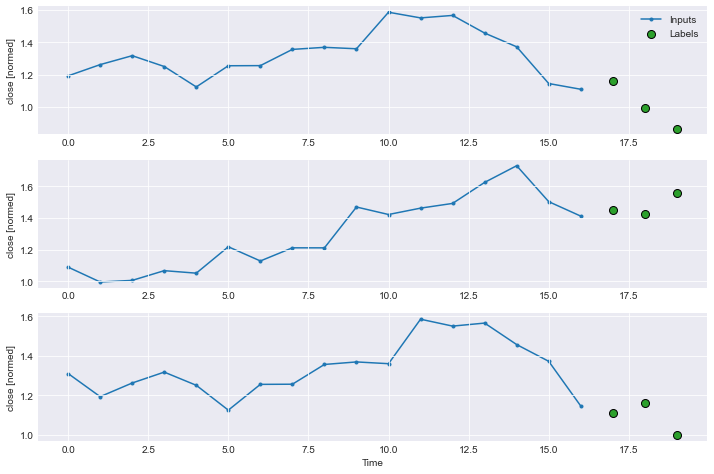

In [28]:
# in put != out put

InputWidth = 14
OuputWidth = 3
Shift = OuputWidth
InputWidth_M2M = OuputWidth + InputWidth

M2MIrregular = WindowGenerator(
    input_width=InputWidth_M2M,
    label_width=OuputWidth,
    shift=Shift,
    label_columns=['close'])


val_performance_M2MIrregular = {}
performance_M2MIrregular = {}

for (example_inputs1, example_inputs2), example_labels in M2MIrregular.train_Ir.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs1.shape}')
    print(f'Inputs shape (batch, time, features): {example_inputs2.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

num_time_i = example_inputs1.shape[1]
num_features_i = example_inputs1.shape[2]
num_time = example_labels.shape[1]
num_features = example_labels.shape[2]
print(num_time_i, num_features_i, num_time,num_features)

M2MIrregular.plot()
M2MIrregular

##### lstm

2/2 [==============================] - 0s 3ms/step - loss: 0.1131 - mean_absolute_error: 0.2880
Input shape: (64, 17, 9)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 17, 9)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                5376      
                                                                 
 repeat_vector (RepeatVector  (None, 3, 32)            0         
 )                                                               
                                                                 
 dense_15 (Dense)            (None, 3, 1)              33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
No

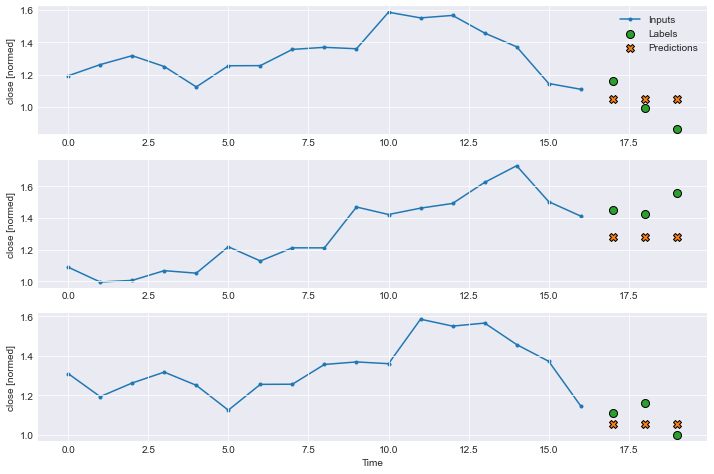

In [29]:
i = tf.keras.layers.Input(shape=(num_time_i, num_features_i))
x = tf.keras.layers.LSTM(32)(i)
x = tf.keras.layers.RepeatVector(num_time)(x)
x = tf.keras.layers.Dense(num_features)(x)
o = x 

lstm_model_M2MIrregular = tf.keras.Model(inputs=i, outputs=o)

history = compile_and_fit(lstm_model_M2MIrregular, M2MIrregular)
IPython.display.clear_output()

val_performance_M2MIrregular['LSTM'] = lstm_model_M2MIrregular.evaluate(M2MIrregular.val)
performance_M2MIrregular['LSTM'] = lstm_model_M2MIrregular.evaluate(M2MIrregular.test, verbose=0)

print('Input shape:', M2MIrregular.example[0].shape)

print(lstm_model_M2MIrregular.summary())

M2MIrregular.plot(lstm_model_M2MIrregular)

#### Residual LSTM

2/2 [==============================] - 0s 3ms/step - loss: 0.0410 - mean_absolute_error: 0.1580
Input shape: (64, 17, 9)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 17, 9)]      0           []                               
                                                                                                  
 lstm_5 (LSTM)                  (None, 32)           5376        ['input_5[0][0]']                
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 3, 32)       0           ['lstm_5[0][0]']                 
                                                                                                  
 dense_16 (Dense)               (None, 3, 1)         33          ['rep

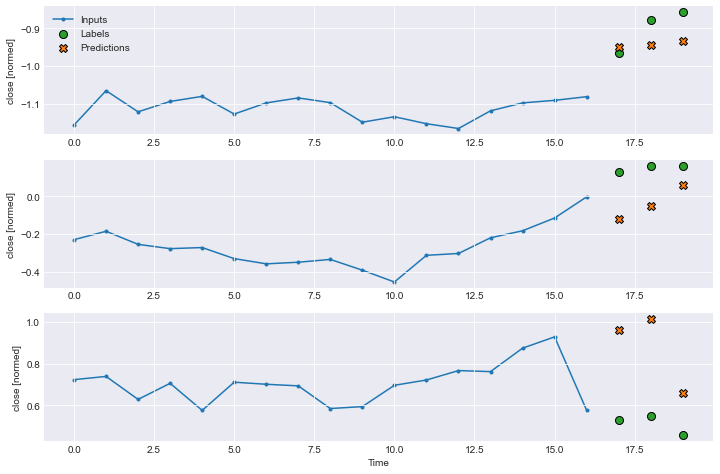

In [30]:
i = tf.keras.layers.Input(shape=(num_time_i, num_features_i))
ii = tf.keras.layers.Input(shape=(num_time, num_features))
x = tf.keras.layers.LSTM(32)(i)
x = tf.keras.layers.RepeatVector(num_time)(x)
x = tf.keras.layers.Dense(num_features)(x)
o = x + ii

residual_lstm_M2MIrregular = tf.keras.Model(inputs=[i,ii], outputs=o)


history = compile_and_fit(residual_lstm_M2MIrregular, window=M2MIrregular, train__=False, nIr=False)
IPython.display.clear_output()

val_performance_M2MIrregular['Residual LSTM'] = residual_lstm_M2MIrregular.evaluate(M2MIrregular.val_Ir)
performance_M2MIrregular['Residual LSTM'] = residual_lstm_M2MIrregular.evaluate(M2MIrregular.test_Ir, verbose=0)

print('Input shape:', M2MIrregular.example[0].shape)

print(residual_lstm_M2MIrregular.summary())

M2MIrregular.plot(residual_lstm_M2MIrregular, train___=False, nIr=False)

#### AR LSTM

2/2 [==============================] - 0s 3ms/step - loss: 0.1813 - mean_absolute_error: 0.3552
Input shape: (64, 17, 9)
Model: "feed_back"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_6 (LSTMCell)      multiple                  5376      
                                                                 
 rnn (RNN)                   multiple                  5376      
                                                                 
 dense_17 (Dense)            multiple                  297       
                                                                 
Total params: 5,673
Trainable params: 5,673
Non-trainable params: 0
_________________________________________________________________
None


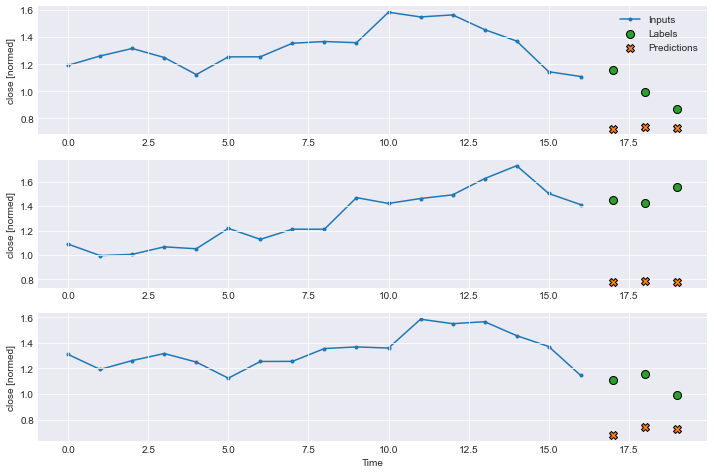

In [31]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features_i)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        x = self.dense(x)
        prediction = x
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            # Execute one lstm step.
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            x = self.dense(x)
            prediction = x
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    
feedback_model_M2MIrregular = FeedBack(units=32, out_steps=num_time)

history = compile_and_fit(feedback_model_M2MIrregular, M2MIrregular)
IPython.display.clear_output()

val_performance_M2MIrregular['AR LSTM'] = feedback_model_M2MIrregular.evaluate(M2MIrregular.val)
performance_M2MIrregular['AR LSTM'] = feedback_model_M2MIrregular.evaluate(M2MIrregular.test, verbose=0)

print('Input shape:', M2MIrregular.example[0].shape)

print(feedback_model_M2MIrregular.summary())

M2MIrregular.plot(feedback_model_M2MIrregular)

### OutPut

LSTM        : 0.4779
Residual LSTM: 0.0774
AR LSTM     : 0.4597


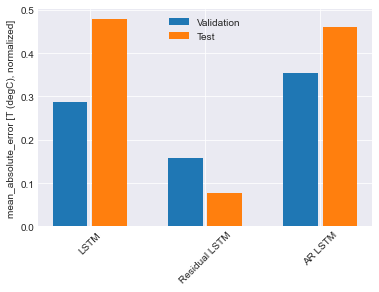

In [32]:
x = np.arange(len(performance_M2MIrregular))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model_M2MIrregular.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_M2MIrregular.values()]
test_mae = [v[metric_index] for v in performance_M2MIrregular.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_M2MIrregular.keys(),
           rotation=45)
_ = plt.legend()


for name, value in performance_M2MIrregular.items():
    print(f'{name:12s}: {value[1]:0.4f}')


# seq2seq

Inputs shape (batch, time, features): (64, 24, 9)
Labels shape (batch, time, features): (64, 24, 1)
24 9 1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['close']

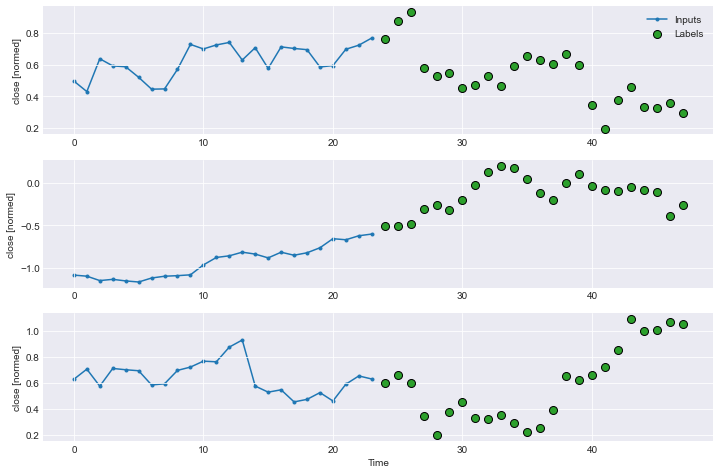

In [33]:
OUT_STEPS = 24
input_width = 24
seq2seq = WindowGenerator(input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['close'])

multi_val_performance_seq2seq = {}
multi_performance_seq2seq = {}

for example_inputs, example_labels in seq2seq.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

num_time = example_labels.shape[1]
num_features_i = example_inputs.shape[2]
num_features = example_labels.shape[2]
print(num_time, num_features_i, num_features)

seq2seq.plot()
seq2seq

#### Dens

2/2 [==============================] - 0s 2ms/step - loss: 0.2236 - mean_absolute_error: 0.4061
Input shape: (64, 24, 9)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 9)              0         
                                                                 
 dense_18 (Dense)            (None, 1, 512)            5120      
                                                                 
 dense_19 (Dense)            (None, 1, 24)             12312     
                                                                 
 reshape_3 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 17,432
Trainable params: 17,432
Non-trainable params: 0
_________________________________________________________________
None


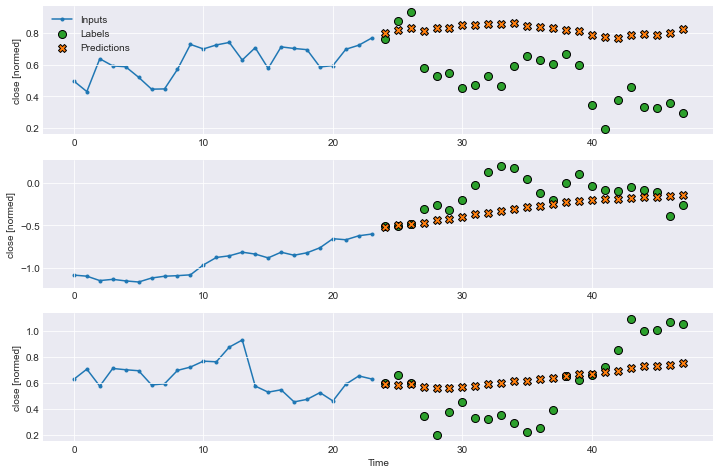

In [34]:
multi_dense_model_seq2seq = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(num_time*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([num_time, num_features])
])

history = compile_and_fit(multi_dense_model_seq2seq, seq2seq)
IPython.display.clear_output()

multi_val_performance_seq2seq['Dense'] = multi_dense_model_seq2seq.evaluate(seq2seq.val)
multi_performance_seq2seq['Dense'] = multi_dense_model_seq2seq.evaluate(seq2seq.test, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(multi_dense_model_seq2seq.summary())

seq2seq.plot(multi_dense_model_seq2seq)

#### Conv

2/2 [==============================] - 0s 2ms/step - loss: 2.3124 - mean_absolute_error: 1.4504
Input shape: (64, 24, 9)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 22, 256)           7168      
                                                                 
 flatten_1 (Flatten)         (None, 5632)              0         
                                                                 
 dense_20 (Dense)            (None, 24)                135192    
                                                                 
 reshape_4 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 142,360
Trainable params: 142,360
Non-trainable params: 0
_________________________________________________________________
None


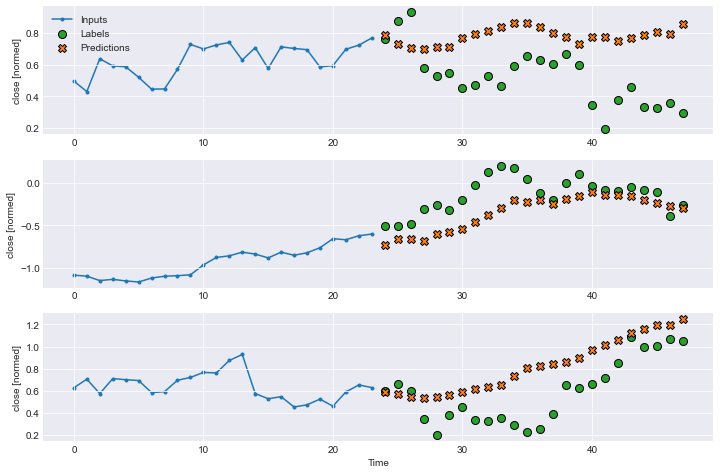

In [35]:
ConvWidth = 3

multi_conv_model_seq2seq = tf.keras.Sequential([

    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(ConvWidth)),
    
    tf.keras.layers.Flatten(),
    
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(num_time*num_features, kernel_initializer=tf.initializers.zeros()),
    
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([num_time, num_features])
])


history = compile_and_fit(multi_conv_model_seq2seq, seq2seq)
IPython.display.clear_output()

multi_val_performance_seq2seq['Conv'] = multi_conv_model_seq2seq.evaluate(seq2seq.val)
multi_performance_seq2seq['Conv'] = multi_conv_model_seq2seq.evaluate(seq2seq.test, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(multi_conv_model_seq2seq.summary())

seq2seq.plot(multi_conv_model_seq2seq)

#### LSTM

2/2 [==============================] - 0s 4ms/step - loss: 0.0734 - mean_absolute_error: 0.2285
Input shape: (64, 24, 9)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                5376      
                                                                 
 dense_21 (Dense)            (None, 24)                792       
                                                                 
 reshape_5 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 6,168
Trainable params: 6,168
Non-trainable params: 0
_________________________________________________________________
None


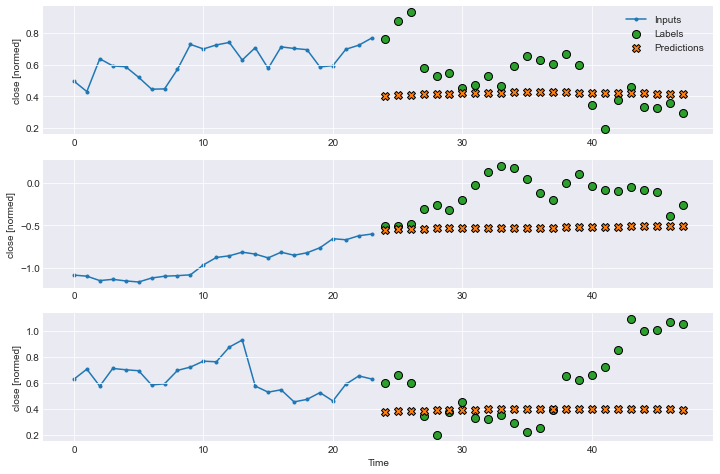

In [36]:
lstm_model_seq2seq = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(num_time*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([num_time, num_features])
])

history = compile_and_fit(lstm_model_seq2seq, seq2seq)
IPython.display.clear_output()

multi_val_performance_seq2seq['LSTM'] = lstm_model_seq2seq.evaluate(seq2seq.val)
multi_performance_seq2seq['LSTM'] = lstm_model_seq2seq.evaluate(seq2seq.test, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(lstm_model_seq2seq.summary())

seq2seq.plot(lstm_model_seq2seq)

#### RV LSTM

2/2 [==============================] - 0s 3ms/step - loss: 0.6057 - mean_absolute_error: 0.7395
Input shape: (64, 24, 9)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                5376      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 24, 32)           0         
 or)                                                             
                                                                 
 dense_22 (Dense)            (None, 24, 1)             33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
None


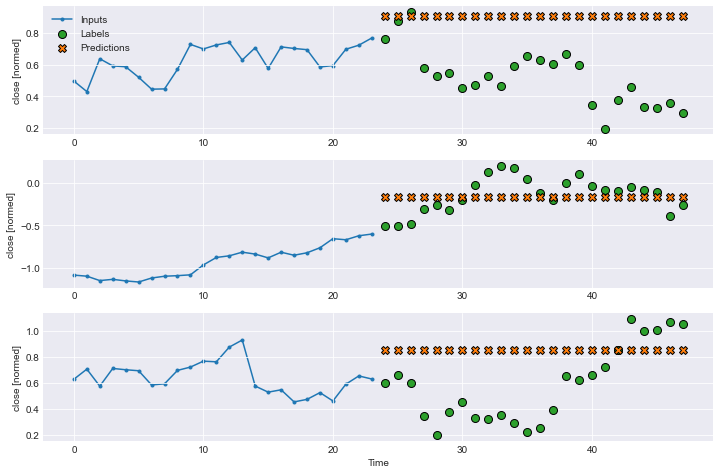

In [37]:
lstm_repeat_vector_model_seq2seq = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32),
    tf.keras.layers.RepeatVector(num_time),
    
    # tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(num_features),
])

history = compile_and_fit(lstm_repeat_vector_model_seq2seq, seq2seq)
IPython.display.clear_output()

multi_val_performance_seq2seq['RV LSTM'] = lstm_repeat_vector_model_seq2seq.evaluate(seq2seq.val)
multi_performance_seq2seq['RV LSTM'] = lstm_repeat_vector_model_seq2seq.evaluate(seq2seq.test, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(lstm_repeat_vector_model_seq2seq.summary())

seq2seq.plot(lstm_repeat_vector_model_seq2seq)

#### Residual LSTM

2/2 [==============================] - 0s 2ms/step - loss: 1.1525 - mean_absolute_error: 1.0369
Input shape: (64, 24, 9)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 32)           5376        ['input_7[0][0]']                
                                                                                                  
 repeat_vector_3 (RepeatVector)  (None, 24, 32)      0           ['lstm_8[0][0]']                 
                                                                                                  
 dense_23 (Dense)               (None, 24, 1)        33          ['rep

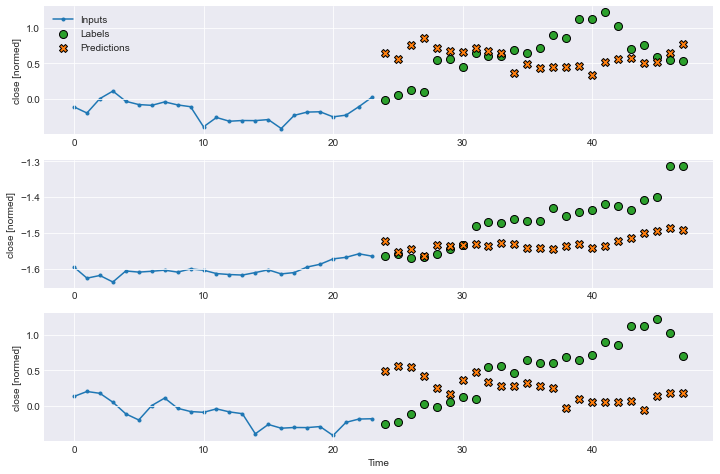

In [38]:
i = tf.keras.layers.Input(shape=(num_time, num_features_i))
ii = tf.keras.layers.Input(shape=(num_time, num_features))
x = tf.keras.layers.LSTM(32)(i)
x = tf.keras.layers.RepeatVector(num_time)(x)
x = tf.keras.layers.Dense(num_features)(x)
o = x + ii

residual_lstm_seq2seq = tf.keras.Model(inputs=[i,ii], outputs=o)


history = compile_and_fit(residual_lstm_seq2seq, window=seq2seq, train__=False)
IPython.display.clear_output()

multi_val_performance_seq2seq['Residual LSTM'] = residual_lstm_seq2seq.evaluate(seq2seq.val_)
multi_performance_seq2seq['Residual LSTM'] = residual_lstm_seq2seq.evaluate(seq2seq.test_, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(residual_lstm_seq2seq.summary())

seq2seq.plot(residual_lstm_seq2seq, train___=False)

#### AR LSTM

2/2 [==============================] - 0s 4ms/step - loss: 0.1781 - mean_absolute_error: 0.3400
Input shape: (64, 24, 9)
Model: "feed_back_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_10 (LSTMCell)     multiple                  5376      
                                                                 
 rnn_1 (RNN)                 multiple                  5376      
                                                                 
 dense_24 (Dense)            multiple                  297       
                                                                 
Total params: 5,673
Trainable params: 5,673
Non-trainable params: 0
_________________________________________________________________
None


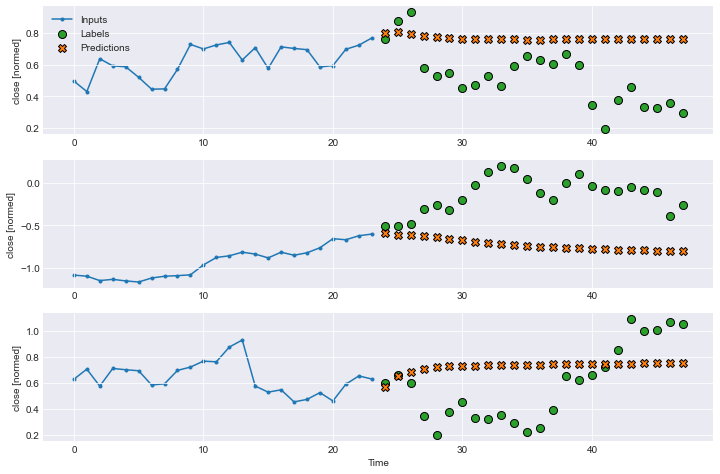

In [39]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features_i)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        x = self.dense(x)
        prediction = x
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            # Execute one lstm step.
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            x = self.dense(x)
            prediction = x
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    
feedback_model_seq2seq = FeedBack(units=32, out_steps=num_time)

history = compile_and_fit(feedback_model_seq2seq, seq2seq)
IPython.display.clear_output()

multi_val_performance_seq2seq['AR LSTM'] = feedback_model_seq2seq.evaluate(seq2seq.val)
multi_performance_seq2seq['AR LSTM'] = feedback_model_seq2seq.evaluate(seq2seq.test, verbose=0)

print('Input shape:', seq2seq.example[0].shape)

print(feedback_model_seq2seq.summary())

seq2seq.plot(feedback_model_seq2seq)

### OutPut

Dense   : 0.3658
Conv    : 0.7738
LSTM    : 0.3395
RV LSTM : 0.4999
Residual LSTM: 0.5115
AR LSTM : 0.4428


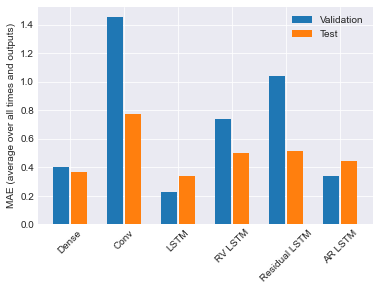

In [40]:
x = np.arange(len(multi_val_performance_seq2seq))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_dense_model_seq2seq.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance_seq2seq.values()]
test_mae = [v[metric_index] for v in multi_performance_seq2seq.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance_seq2seq.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in multi_performance_seq2seq.items():
    print(f'{name:8s}: {value[1]:0.4f}')